# Code chunks for Exercise 1

Welcome to this Jupyter notebook collecting many code chunks that are useful for the MRS UE exercises. It presents typical Python tools for working with geo data, as also used in professional remote sensing. A focus is put on the first exercise, i.e. classifying forests with optical imagery.

## Some Python libraries you might need


A lot of libraries will be used for the exercise, but don't get intimidated by the amout of imports. They mostly fulfill small tasks.

First, we import some popular, useful libraries.


In [1]:
import cv2
import datetime
import numpy as np
import pandas as pd
import xarray as xar
import os

Then, we continue with in-house production software for all sorts of data processing. For more information have a look at https://github.com/TUW-GEO.


In [2]:
from geospade.crs import SpatialRef
from veranda.io.geotiff import write_tiff

Several tasks cannot be solely managed with the existing general-purpose packages. Therefore, we have created a helper package dedicated for this lecture.


In [3]:
from afe.add_ons import generate_tree
from afe.add_ons import OpticalDataCube
from afe.geometry import PolygonCollection

Next, we import the `scikit-learn` machine learning framework.


In [4]:
from sklearn import svm, tree
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

Now, we import `matplotlib` for interactive plots and `roi` to draw polygons and export them as geojson files.


In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from ipywidgets import widgets, FloatSlider

Finally, we import our own python scripts


and activate its `widget` backend.


In [6]:
%matplotlib widget
%matplotlib widget

It is generally a good idea to run these widget-commands twice to avoid issues when changing the backend (https://matplotlib.org/2.0.2/faq/usage_faq.html#what-is-a-backend).


To allow for running the code chunks for any user, we can globally define our username here.


In [7]:
USER = os.getcwd().split('/')[
    2]  #This command should automatically get your username
USER

'e12334178'

In [8]:
from afe.contrast import auto_clip, clip, stretch
from afe.imagechoice import quicklook, display_extent
from afe.roi import roi

## Imagesearch


Since Jupyterhub does not display the QTCI images and for easier identification of the quality of your image, you can use the python script shown in the following cells.
In the first step, we have to establish the path, which leads us to the available tiles. Next we use the function `quicklook`, the parameters `tile` and `img` should be empty at first, so that we can choose the tile and later the image. The function will ask you for an input, aslong asat least on of the parameters is empty.


Idx  Tile
0    .ipynb_checkpoints
1            E048N015T1
2            E050N016T1
3            E051N015T1
4            E051N016T1
5            E052N015T1
6            E052N016T1
dtype: object 



	Tile:  E052N016T1


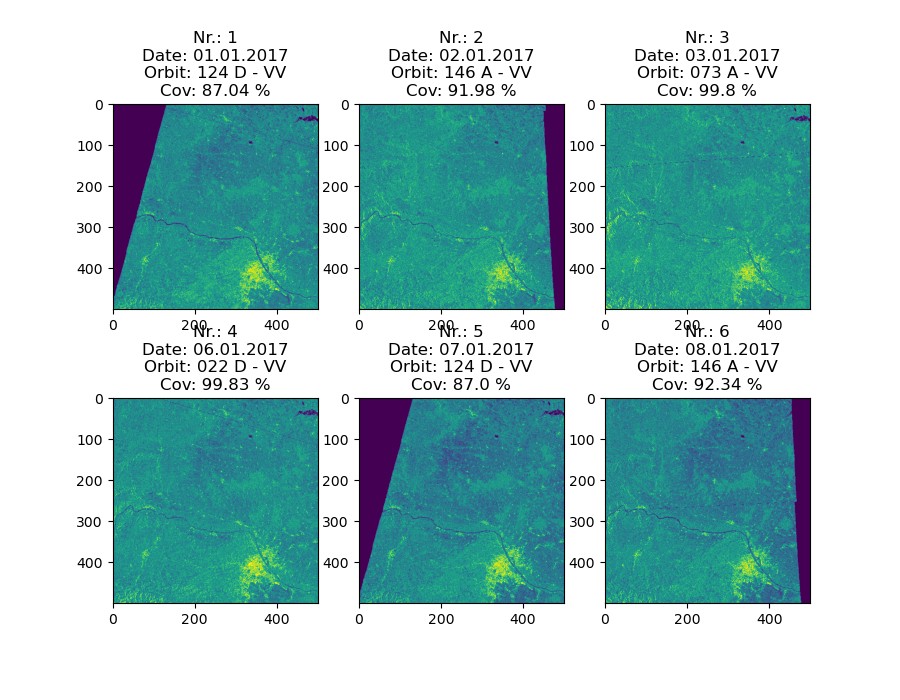

In [11]:
gen_path = f'/home/{USER}/shared/datasets/fe/data/'
rootpath = gen_path + f'sentinel1/preprocessed/EU010M'
image = quicklook(rootpath, tile='', img='', figsize=(9, 7))

Tile:  E052N016T1


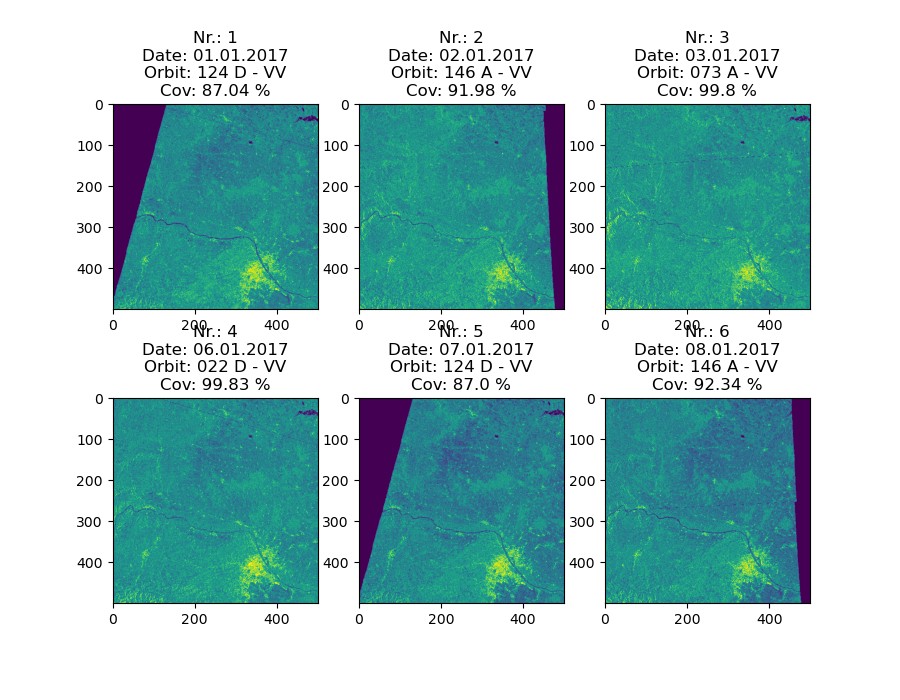

In [12]:
image = quicklook(rootpath, tile='6', img='', figsize=(9, 7))

In [13]:
ul_col, ul_row = 9000, 2800
col_size, row_size = 800, 800

TypeError: Image data of dtype object cannot be converted to float

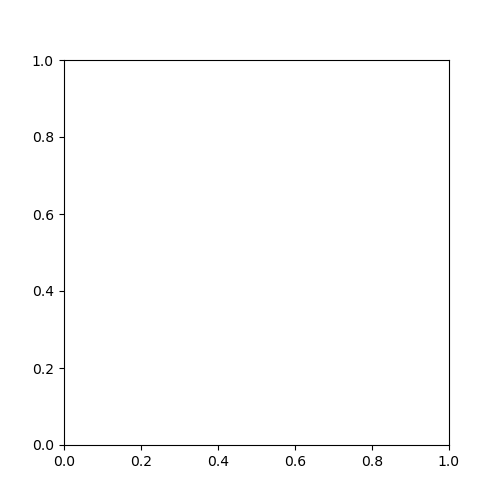

In [14]:
display_extent(image,
               ul_col=ul_col,
               ul_row=ul_row,
               col_size=col_size,
               row_size=row_size,
               title='Sub Area')

## Xarray


The loaded data is in a structure called `xarray` there are many ways to manipulate a data array and get information out of it. For this example we will create a simple 2D xarray with the coordinates `cities` and `time` and temperature regarding variables:


In [15]:
times = pd.date_range("2014-09-06", periods=3)
cities = ["Munich", "Vienna", "Berlin", "London", "Rome"]

max_temps = np.random.uniform(low=25, high=38, size=(5, 3))
avg_temps = np.random.uniform(low=20, high=30, size=(5, 3))
min_temps = np.random.uniform(low=15, high=25, size=(5, 3))
humidity = np.random.uniform(low=15, high=100, size=(5, 3))

temp_ds = xar.Dataset(coords={
    "city": cities,
    "time": times,
},
                      data_vars={
                          "min_temperature": (["city", "time"], min_temps),
                          "avg_temperature": (["city", "time"], avg_temps),
                          "max_temperature": (["city", "time"], max_temps),
                          "humidity": (["city", "time"], humidity)
                      })
temp_ds

<xarray.Dataset>
Dimensions:          (city: 5, time: 3)
Coordinates:
  * city             (city) <U6 'Munich' 'Vienna' 'Berlin' 'London' 'Rome'
  * time             (time) datetime64[ns] 2014-09-06 2014-09-07 2014-09-08
Data variables:
    min_temperature  (city, time) float64 23.21 17.78 22.69 ... 19.25 23.24
    avg_temperature  (city, time) float64 23.26 26.72 21.05 ... 22.36 24.63
    max_temperature  (city, time) float64 25.83 37.24 30.19 ... 29.42 33.39
    humidity         (city, time) float64 64.57 84.73 73.08 ... 38.15 32.21

We can define a new xarray dataset `temps_mean`: `dim` specifies the dimension to apply the mean along. `skipna` is used to signal that NaN (Not-a-Number) values should be ignored. Keep this in mind, you will have to use `skipna` in combination with another function.


In [14]:
temps_mean = temp_ds.mean(dim="time", skipna=False)
temps_mean

<xarray.Dataset>
Dimensions:          (city: 5)
Coordinates:
  * city             (city) <U6 'Munich' 'Vienna' 'Berlin' 'London' 'Rome'
Data variables:
    min_temperature  (city) float64 22.75 22.77 19.31 18.14 19.7
    avg_temperature  (city) float64 25.81 25.59 22.02 24.49 27.99
    max_temperature  (city) float64 33.59 32.02 29.52 31.99 29.48
    humidity         (city) float64 51.29 51.74 70.92 91.43 65.55

We can also extract the values of a single variable:


In [15]:
min_temps = temps_mean['min_temperature']
min_temps

<xarray.DataArray 'min_temperature' (city: 5)>
array([22.75159645, 22.76501733, 19.30552726, 18.14420856, 19.69592417])
Coordinates:
  * city     (city) <U6 'Munich' 'Vienna' 'Berlin' 'London' 'Rome'

xarray extensively uses the popular `numpy` library in its background.

In case you want to extract a `numpy` array from your `xarray` data, which is sometimes needed, you can do that by:

1. (optional) converting your `xarray.Dataset` to `xarray.DataArray` by calling `to_array()` , which removes your data variables but keeps all your data in an n-dimensional array.
2. accessing your `xarray.DataArray`'s `values` property


In [16]:
temps_mean.to_array().values

array([[22.75159645, 22.76501733, 19.30552726, 18.14420856, 19.69592417],
       [25.80947005, 25.59371068, 22.02444025, 24.49222692, 27.98518277],
       [33.59368755, 32.0157725 , 29.5242913 , 31.98617652, 29.47635175],
       [51.28507256, 51.73937596, 70.92344995, 91.42753702, 65.55103644]])

## Image processing


### Stacking


With the xarray created by loading the Sentinel 2 data we cannot just yet create a meaningful image. As we have already seen in the loaded xarray we have nine different bands available for each time, x and y-coordinate.

-   B02: Blue
-   B03: Green
-   B04: Red
-   B05: Vegetation red edge
-   B06: Vegetation red edge
-   B07: Vegetation red edge
-   B08: NIR
-   B11: SWIR
-   B12: SWIR

We have to extract the bands we need from our xarray in order to create an rgb-image. To do this we have to stack the concerned bands with the function `np.stack`. In the following cells the stacking of the images is explained with a simple example, so that you understand it better.

First we create a 4 by 4 pixelgrid with random values.


In [17]:
x_pixel = 4
y_pixel = 4

#R Values
r_val = np.round(np.random.rand(x_pixel, y_pixel), 2)
r_val[0, 0] = 0
r_val[x_pixel - 1, y_pixel - 1] = 1

#G Values
g_val = np.round(np.random.rand(x_pixel, y_pixel), 2)
g_val[0, 0] = 0
g_val[x_pixel - 1, y_pixel - 1] = 1

#B Values
b_val = np.round(np.random.rand(x_pixel, y_pixel), 2)
b_val[0, 0] = 0
b_val[x_pixel - 1, y_pixel - 1] = 1

#Stacked arrays at different axis
rgb_ax2 = np.stack([r_val, g_val, b_val], axis=2)
rgb_ax0 = np.stack([r_val, g_val, b_val], axis=0)
rgb_ax1 = np.stack([r_val, g_val, b_val], axis=1)

print('Shape of R,G,B Values (x,y):', r_val.shape)
print('Shape of RGB stacke on axis=2: (x,y,z)=', rgb_ax2.shape)
print('Shape of RGB stacke on axis=1: (x,z,y)=', rgb_ax1.shape)
print('Shape of RGB stacke on axis=0: (z,x,y)=', rgb_ax0.shape)
print(
    'Images stacked at axis 0 or 1 are not plottable! Except in some cases when x and y is the same.'
)

Shape of R,G,B Values (x,y): (4, 4)
Shape of RGB stacke on axis=2: (x,y,z)= (4, 4, 3)
Shape of RGB stacke on axis=1: (x,z,y)= (4, 3, 4)
Shape of RGB stacke on axis=0: (z,x,y)= (3, 4, 4)
Images stacked at axis 0 or 1 are not plottable! Except in some cases when x and y is the same.


Now we plot the RGB values separately and stack them along different axis. As you can see the stacke array along axis = 0 is not possible.


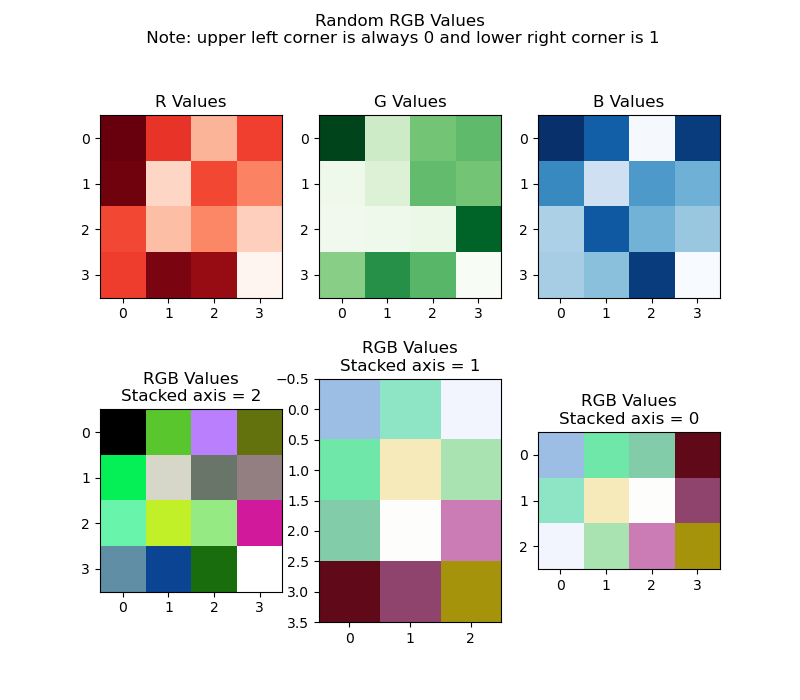

In [18]:
fig, ax = plt.subplots(2, 3, figsize=(8, 7))
ax[0, 0].imshow(r_val, cmap='Reds_r')
ax[0, 1].imshow(g_val, cmap='Greens_r')
ax[0, 2].imshow(b_val, cmap='Blues_r')

ax[1, 0].imshow(rgb_ax2)
ax[1, 1].imshow(rgb_ax1)
ax[1, 2].imshow(rgb_ax0)

ax[0, 0].set_title('R Values')
ax[0, 1].set_title('G Values')
ax[0, 2].set_title('B Values')
ax[1, 0].set_title('RGB Values\nStacked axis = 2')
ax[1, 1].set_title('RGB Values\nStacked axis = 1')
ax[1, 2].set_title('RGB Values\nStacked axis = 0')

fig.suptitle(
    'Random RGB Values\n Note: upper left corner is always 0 and lower right corner is 1'
)

plt.show()

### Histogram


It is very helpful creating a histogram for your images. A histogram shows the distribution of your pixel values in regards to their color intenensity, meaning low intensities bring dark pixels (black=0) and high intensities bright pixels (white=1).

To create a histogram you can use the `hist()` function. Be careful as it only accepts one dimensional arrays. The dimension of an array can be reduced using the `flatten()` function. As we want to show the distribution for each band seperately we have to extract the bands from the rgb-image first.


In [19]:
def plot_rgb_histogram(rgb_im, ax, title, bins=300):
    mbins = np.linspace(np.nanmin(rgb_im), np.nanmax(rgb_im), bins)
    ax.hist(rgb_im[:, :, 2].flatten(), color='blue', bins=mbins, alpha=0.5)
    ax.hist(rgb_im[:, :, 1].flatten(), color='green', bins=mbins, alpha=0.5)
    ax.hist(rgb_im[:, :, 0].flatten(), color='red', bins=mbins, alpha=0.5)

    ax.set_title(title)
    ax.set_xlabel('I')
    ax.set_ylabel('n')

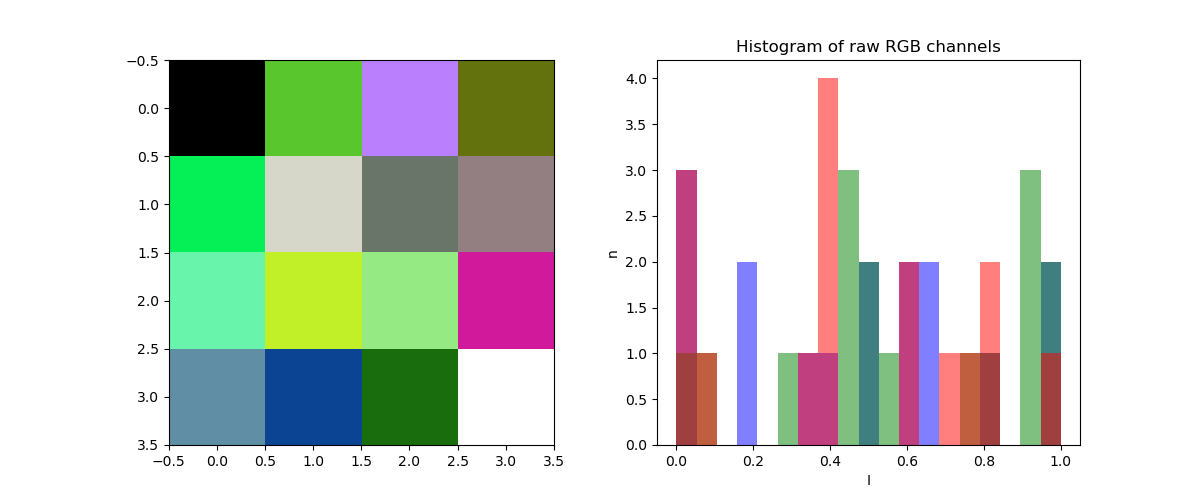

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_rgb_histogram(rgb_ax2, ax[1], 'Histogram of raw RGB channels', bins=20)
ax[0].imshow(rgb_ax2)

### Clip and increase contrast of images


To fix this problem we can increase the contrast of the image. To do this we implement the following functions, which will be needed for processing your image. For more details on how these functions work and why we need them to increase contrast and correctly encode the data, take a look at https://www.cg.tuwien.ac.at/courses/EinfVisComp/Skriptum/SS13/EVC-11%20Point%20Operations.pdf for a great overview.

The Contrast functions are explained in more detail in the other code chunks. Here the functions are only imported and not directly defined.

First we load an random image for exemplary use.


In [21]:
gen_path = f'/home/{USER}/shared/datasets/fe/data/'
root_dirpath = gen_path + f'sentinel2/L2A'
dir_tree = generate_tree(root_dirpath)
filepaths = dir_tree.file_register
dc = OpticalDataCube(filepaths=filepaths)

In [22]:
#Filter Parameter
Tile = 'E052N016T1'
Spectral_band = dc.SPECTRAL_BANDS[0:3]
Date = datetime.date(2018, 5, 6)

delta = 10
Date_tuple = (Date - datetime.timedelta(days=delta),
              Date + datetime.timedelta(days=delta))

In [23]:
dc.filter_spatially_by_tilename(Tile, inplace=True)
dc.filter_by_dimension(Spectral_band, name="var_name", inplace=True)
dc.filter_by_dimension([Date_tuple],
                       expressions=[('>=', '<=')],
                       name='time',
                       inplace=True)
dc.inventory

filepath var_name        time  \
0   /home/e12334178/shared/datasets/fe/data/sentin...      B02  2018-04-29   
1   /home/e12334178/shared/datasets/fe/data/sentin...      B02  2018-05-03   
2   /home/e12334178/shared/datasets/fe/data/sentin...      B02  2018-05-06   
3   /home/e12334178/shared/datasets/fe/data/sentin...      B02  2018-05-09   
4   /home/e12334178/shared/datasets/fe/data/sentin...      B02  2018-05-13   
5   /home/e12334178/shared/datasets/fe/data/sentin...      B02  2018-05-16   
6   /home/e12334178/shared/datasets/fe/data/sentin...      B02  2018-04-28   
7   /home/e12334178/shared/datasets/fe/data/sentin...      B02  2018-05-04   
8   /home/e12334178/shared/datasets/fe/data/sentin...      B02  2018-05-08   
9   /home/e12334178/shared/datasets/fe/data/sentin...      B02  2018-05-11   
10  /home/e12334178/shared/datasets/fe/data/sentin...      B02  2018-05-14   
11  /home/e12334178/shared/datasets/fe/data/sentin...      B03  2018-04-29   
12  /home/e12334178/shared/datasets/fe/data/sentin...      B03  2018-05-03   
13  /home/e12334178/shared/datasets/fe/data/sentin...      B03  2018-05-06   
14  /home/e12334178/shared/datasets/fe/data/sentin...      B03  2018-05-09   
15  /home/e12334178/shared/datasets/fe/data/sentin...      B03  2018-05-13   
16  /home/e12334178/shared/datasets/fe/data/sentin...      B03  2018-05-16   
17  /home/e12334178/shared/datasets/fe/data/sentin...      B03  2018-04-28   
18  /home/e12334178/shared/datasets/fe/data/sentin...      B03  2018-05-04   
19  /home/e12334178/shared/datasets/fe/data/sentin...      B03  2018-05-08   
20  /home/e12334178/shared/datasets/fe/data/sentin...      B03  2018-05-11   
21  /home/e12334178/shared/datasets/fe/data/sentin...      B03  2018-05-14   
22  /home/e12334178/shared/datasets/fe/data/sentin...      B04  2018-04-29   
23  /home/e12334178/shared/datasets/fe/data/sentin...      B04  2018-05-03   
24  /home/e12334178/shared/datasets/fe/data/sentin...      B04  2018-05-06   
25  /home/e12334178/shared/datasets/fe/data/sentin...      B04  2018-05-09   
26  /home/e12334178/shared/datasets/fe/data/sentin...      B04  2018-05-13   
27  /home/e12334178/shared/datasets/fe/data/sentin...      B04  2018-05-16   
28  /home/e12334178/shared/datasets/fe/data/sentin...      B04  2018-04-28   
29  /home/e12334178/shared/datasets/fe/data/sentin...      B04  2018-05-04   
30  /home/e12334178/shared/datasets/fe/data/sentin...      B04  2018-05-08   
31  /home/e12334178/shared/datasets/fe/data/sentin...      B04  2018-05-11   
32  /home/e12334178/shared/datasets/fe/data/sentin...      B04  2018-05-14   

     tile_name  
0   E052N016T1  
1   E052N016T1  
2   E052N016T1  
3   E052N016T1  
4   E052N016T1  
5   E052N016T1  
6   E052N016T1  
7   E052N016T1  
8   E052N016T1  
9   E052N016T1  
10  E052N016T1  
11  E052N016T1  
12  E052N016T1  
13  E052N016T1  
14  E052N016T1  
15  E052N016T1  
16  E052N016T1  
17  E052N016T1  
18  E052N016T1  
19  E052N016T1  
20  E052N016T1  
21  E052N016T1  
22  E052N016T1  
23  E052N016T1  
24  E052N016T1  
25  E052N016T1  
26  E052N016T1  
27  E052N016T1  
28  E052N016T1  
29  E052N016T1  
30  E052N016T1  
31  E052N016T1  
32  E052N016T1

In [24]:
ul_col, ul_row = 9000, 2800
col_size, row_size = 800, 800

In [25]:
loaded_data = dc.load_available_bands_by_pixels(ul_col, ul_row, col_size,
                                                row_size)
single_image = loaded_data.sel(time=Date)
single_image

<xarray.Dataset>
Dimensions:  (y: 800, x: 800)
Coordinates:
    time     object 2018-05-06
  * y        (y) float64 1.61e+06 1.61e+06 1.61e+06 ... 1.602e+06 1.602e+06
  * x        (x) float64 5.228e+06 5.228e+06 5.228e+06 ... 5.236e+06 5.236e+06
Data variables:
    B02      (y, x) float64 0.0246 0.0266 0.0238 0.0156 ... 0.0131 0.017 0.0123
    B03      (y, x) float64 0.06 0.0628 0.0578 0.0289 ... 0.0313 0.0406 0.0305
    B04      (y, x) float64 0.0306 0.0338 0.0317 0.016 ... 0.018 0.0171 0.0134

We have now filtered the Datacube for our likeing and we are going to load the RGB Values and stack them.


In [26]:
b02 = single_image['B02'].values
b03 = single_image['B03'].values
b04 = single_image['B04'].values
rgb_raw = np.stack([b04, b03, b02], axis=2)

Now we plot the image and its Histogram. as you can see the contrast in the image is terrible.


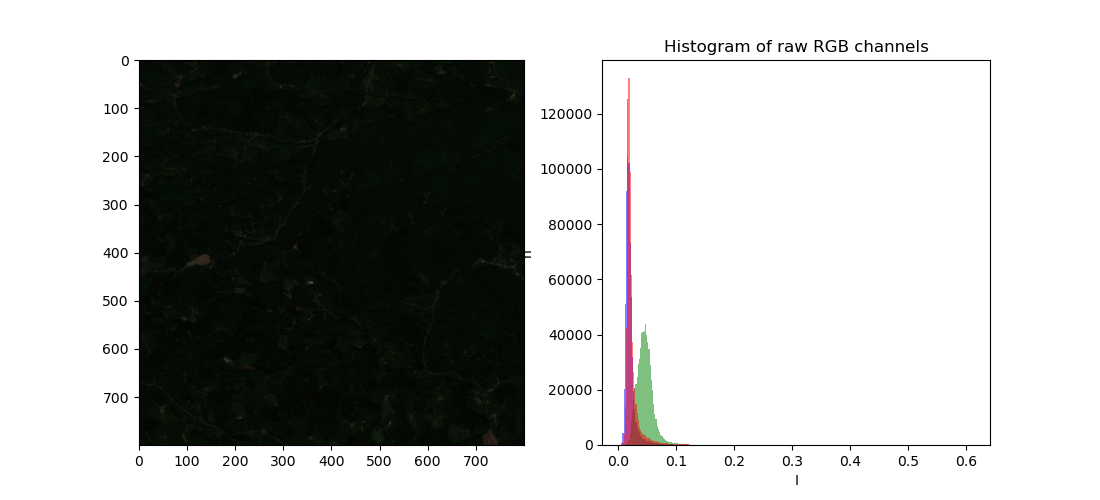

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
plot_rgb_histogram(rgb_raw, ax[1], 'Histogram of raw RGB channels', bins=300)

ax[0].imshow(rgb_raw)
plt.show()

Now we clip the data, inorder to increase the contrast. Sets all values in I that are outside of [v_min, v_max] to the corresponding boundary, in this case defined by the percentile


In [28]:
rgb_clipped = auto_clip(rgb_raw.copy(), percentile=0.02)

We can create a histogram with the clipped data:


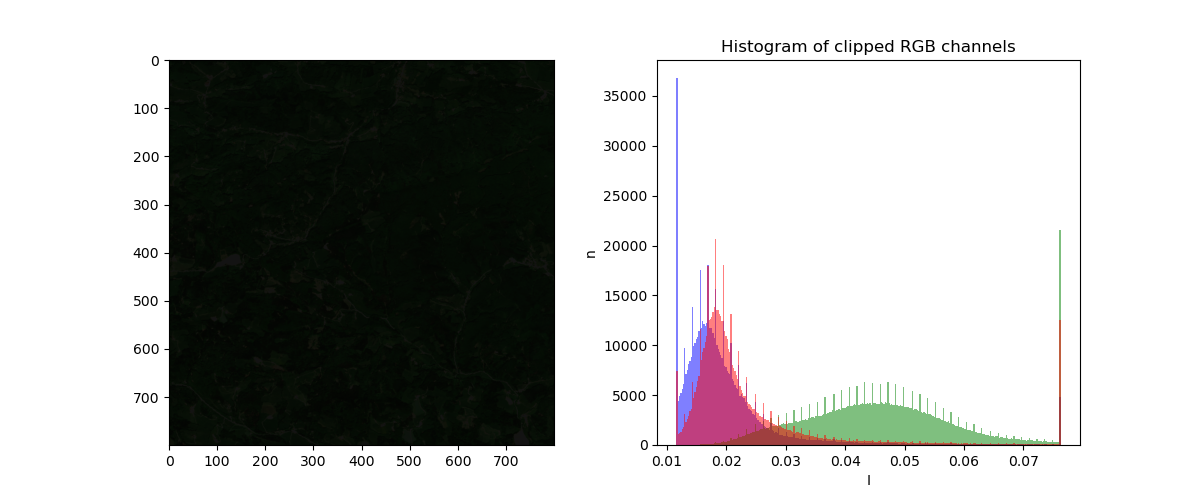

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plot_rgb_histogram(rgb_clipped, ax[1], 'Histogram of clipped RGB channels')
ax[0].imshow(rgb_clipped)

You can see that the histogram now has clear borders, and all the values below/above these borders have been set to the border values. You can play around clipping fewer/more values by setting the percentile value in the `auto_clip()` function. The `pooled` parameter sets if the bands get clipped individually (`=FALSE`) or as a group (`=TRUE`).

As the intensity of the values is still too low after clipping we have to stretch the values to spread between 0 and 1. We can do this by using the `stretch()` function.


In [30]:
rgb_clipped_stretched = stretch(rgb_clipped, 0, 1, pooled=True)

Lets show the final results:


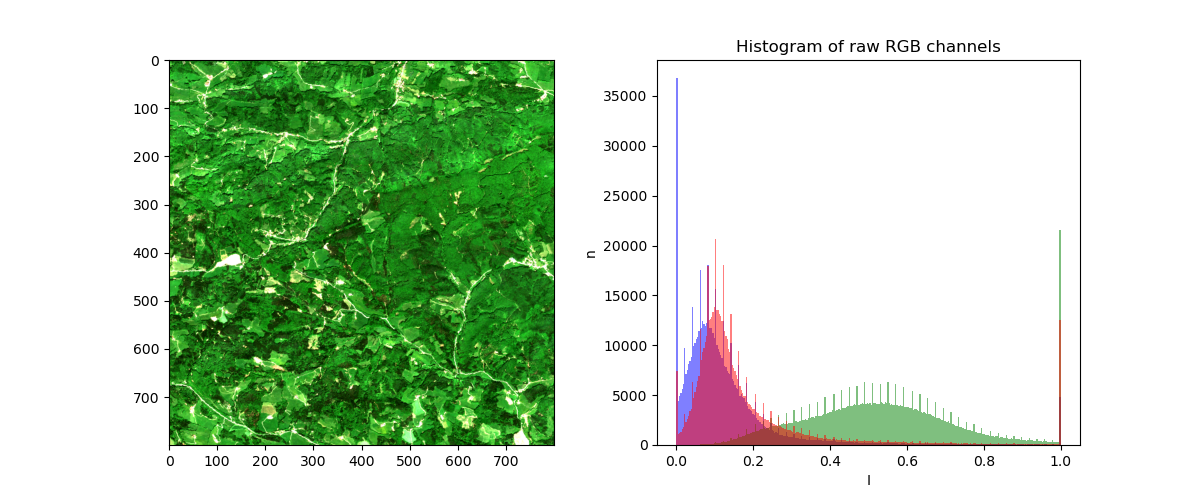

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_rgb_histogram(rgb_clipped_stretched, ax[1],
                   'Histogram of raw RGB channels')
ax[0].imshow(rgb_clipped_stretched)

If the final image still has a too low contrast you can try increasing the `percentile` parameter in the `auto_clip` function or try using the `np.log` function on the raw image before clipping and stretching it.

You can see what happens when we play around with the `percentile` parameter in the `auto_clip` function or use the `np.log` function below:


Text(0.5, 1.0, 'log and percentile = 0.05')

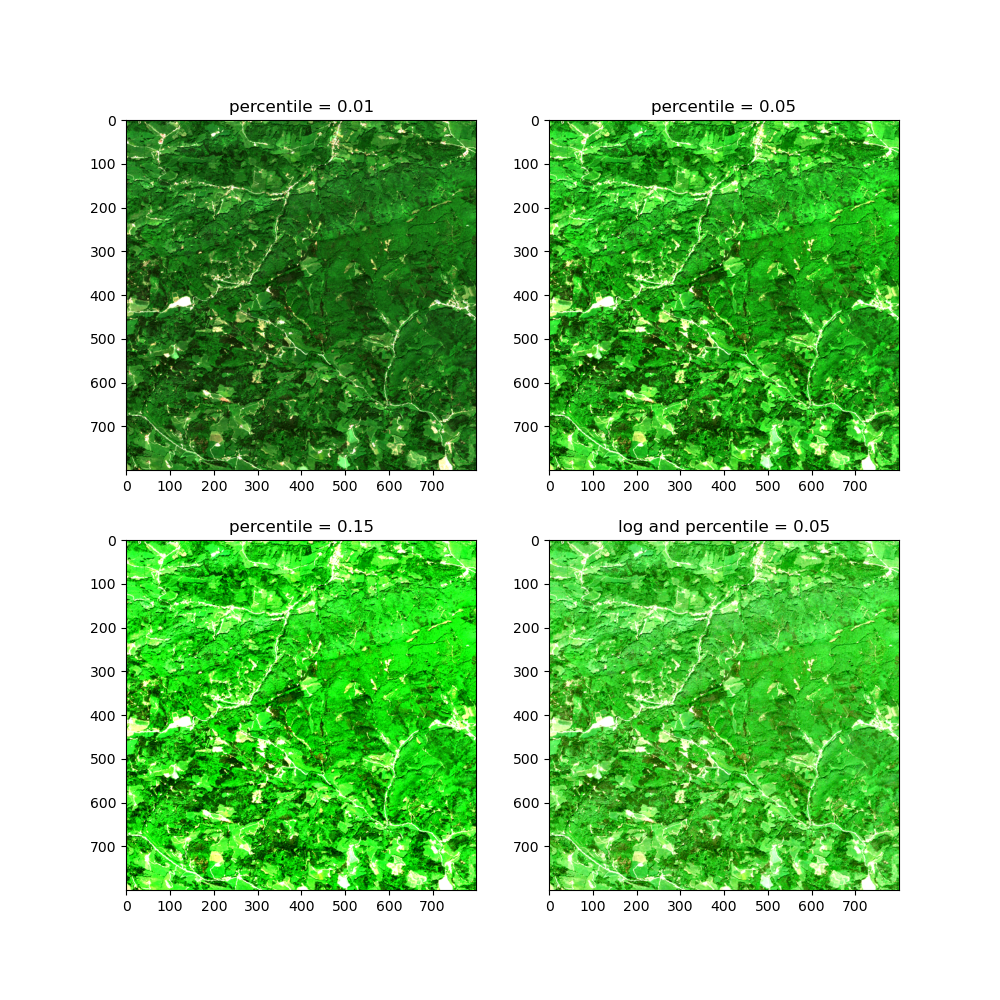

In [32]:
rgb_clipped_stretched_01 = stretch(auto_clip(rgb_raw.copy(), percentile=0.01),
                                   0, 1)
rgb_clipped_stretched_05 = stretch(auto_clip(rgb_raw.copy(), percentile=0.05),
                                   0, 1)
rgb_clipped_stretched_15 = stretch(auto_clip(rgb_raw.copy(), percentile=0.15),
                                   0, 1)
rgb_clipped_stretched_log = stretch(
    auto_clip(np.log(rgb_raw.copy()), percentile=0.05), 0, 1)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(rgb_clipped_stretched_01)
ax[0, 0].set_title("percentile = 0.01")
ax[0, 1].imshow(rgb_clipped_stretched_05)
ax[0, 1].set_title("percentile = 0.05")
ax[1, 0].imshow(rgb_clipped_stretched_15)
ax[1, 0].set_title("percentile = 0.15")
ax[1, 1].imshow(rgb_clipped_stretched_log)
ax[1, 1].set_title("log and percentile = 0.05")

## Calculating NDVI


NDVI and many other indices rely on the normalized difference, represented by the function below


In [33]:
def normalized_difference(a, b):
    return (a - b) / (a + b)


def ndvi(xar_data):
    return normalized_difference(xar_data['<band A>'], xar_data['<band B>'])

The `ndvi` function takes an `xarray.Dataset` where both `'<band A>'` and `'<band B>'` are data variables and returns an `xarray.DataArray` for the resulting NDVI. Note, that `'<band A>'` and `'<band B>'` are only placeholders. Think about which bands have to be used for computing the NDVI.


## Creating logical matrices

Generate random 100x100 matrix filled with values from 0 to 1.


In [34]:
rand_mat = np.random.rand(100, 100)

Create a logical matrix with the same dimensions as `rand_mat`, where values greater than 0.7 are assigned `True`, the rest is `False`:


In [35]:
log_mat = (rand_mat > 0.7)
log_mat

array([[False, False, False, ...,  True, False, False],
       [ True,  True, False, ...,  True, False, False],
       [False, False, False, ...,  True, False, False],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True, False]])

Such a logical matrix can then be applied to mask values in a fashionable manner.


In [36]:
42 * True

42

In [37]:
123 * False

0

In [38]:
np.array([[1, 2], [3, 4]]) * np.array([[True, False], [False, True]])

array([[1, 0],
       [0, 4]])

In [39]:
rand_mat * log_mat

array([[0.        , 0.        , 0.        , ..., 0.82453998, 0.        ,
        0.        ],
       [0.87548119, 0.86026314, 0.        , ..., 0.70523458, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.90699947, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.95841012],
       [0.        , 0.        , 0.        , ..., 0.91479258, 0.7423148 ,
        0.87038251],
       [0.        , 0.        , 0.        , ..., 0.96085368, 0.98545552,
        0.        ]])